<h1 align="left">Channels and NDVI Experimentation</h1>

<p align="left"><i>PASTIS24 Dataset</i></p>

<p align="left">
  ITESM
  
  <a href="https://www.linkedin.com/in/juanrtato/">Juan Ricardo Albarracin B.</a>
  <br>
  <a href="">Luis Ángel Oporto Añacato.</a>
  <br>
  <a href="">David Alexis García Espinosa.</a>
  <br>
  <b>Last updated:</b> <i>10/05/2025</i>
  <br><br>
  <a target="_blank">
    <img src="https://github.com/QData/TextAttack/workflows/Github%20PyTest/badge.svg" alt="Testing">
  </a>
  <a href="https://img.shields.io/badge/version-0.1.0-blue.svg?cacheSeconds=2592000">
    <img src="https://img.shields.io/badge/version-0.1.0-blue.svg?cacheSeconds=2592000" alt="Version" height="18">
  </a>
</p><br>

In [1]:
PATH_TO_PASTIS = '../datalake/PASTIS24'
PATH_TO_CODE = '../scripts/pastis24'
PATH_TO_FOLDS = '../datalake/PASTIS24/fold-paths'
PATH_TO_PICKLES = '../datalake/PASTIS24/pickle24X24'
CONFIG_PATH = '../datalake/config.json'
METADATA_PATH = '../datalake/PASTIS24/metadata.geojson'

In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'scripts')))
#sys.path.append(PATH_TO_CODE)

In [3]:
import ast
import json
import re
import random
from datetime import datetime, timedelta
from itertools import islice
import plotly.express as px

import pandas as pd
from matplotlib import pyplot as plt

import pastis24
from pastis24 import get_dataloaders

from utils import plot_sample_rgb, plot_seg_mask, plot_mean_band_profile

In [4]:
with open(METADATA_PATH, 'r') as f:
    metadata_json = json.load(f)

In [5]:
with open(CONFIG_PATH, 'r') as f:
    config = json.load(f)

In [6]:
with open("../datalake/label_names_en.json", "r") as json_file:
    label_names_en = json.load(json_file)

In [7]:
with open("../datalake/colormap.txt", "r") as txt_file:
    colormap = txt_file.readlines()
colormap = [ast.literal_eval(line.strip().rstrip(',')) for line in colormap]

In [8]:
data = []
for feature in metadata_json["features"]:
    properties = feature["properties"]
    data.append(properties)

metadata_df = pd.DataFrame(data)
metadata_df.head()

,Fold,ID_PATCH,N_Parcel,Parcel_Cover,TILE,dates-S2,id
0,1,10000,119,0.808032,t30uxv,"{'0': 20180924, '1': 20180929, '2': 20181004, ...",10000
1,2,10001,111,0.501986,t30uxv,"{'0': 20180924, '1': 20180929, '2': 20181004, ...",10001
2,4,10002,131,0.638722,t30uxv,"{'0': 20180924, '1': 20180929, '2': 20181004, ...",10002
3,5,10003,75,0.866824,t30uxv,"{'0': 20180924, '1': 20180929, '2': 20181004, ...",10003
4,4,10004,46,0.204906,t30uxv,"{'0': 20180924, '1': 20180929, '2': 20181004, ...",10004


In [9]:
dataloaders = get_dataloaders(config)

Dataset length: 36375
Dataset length: 12050


../datalake/PASTIS24/pickle24x24/30556_13.pickle
Sample shape: (60, 24, 24, 11)
Sample labels shape: (24, 24, 1)


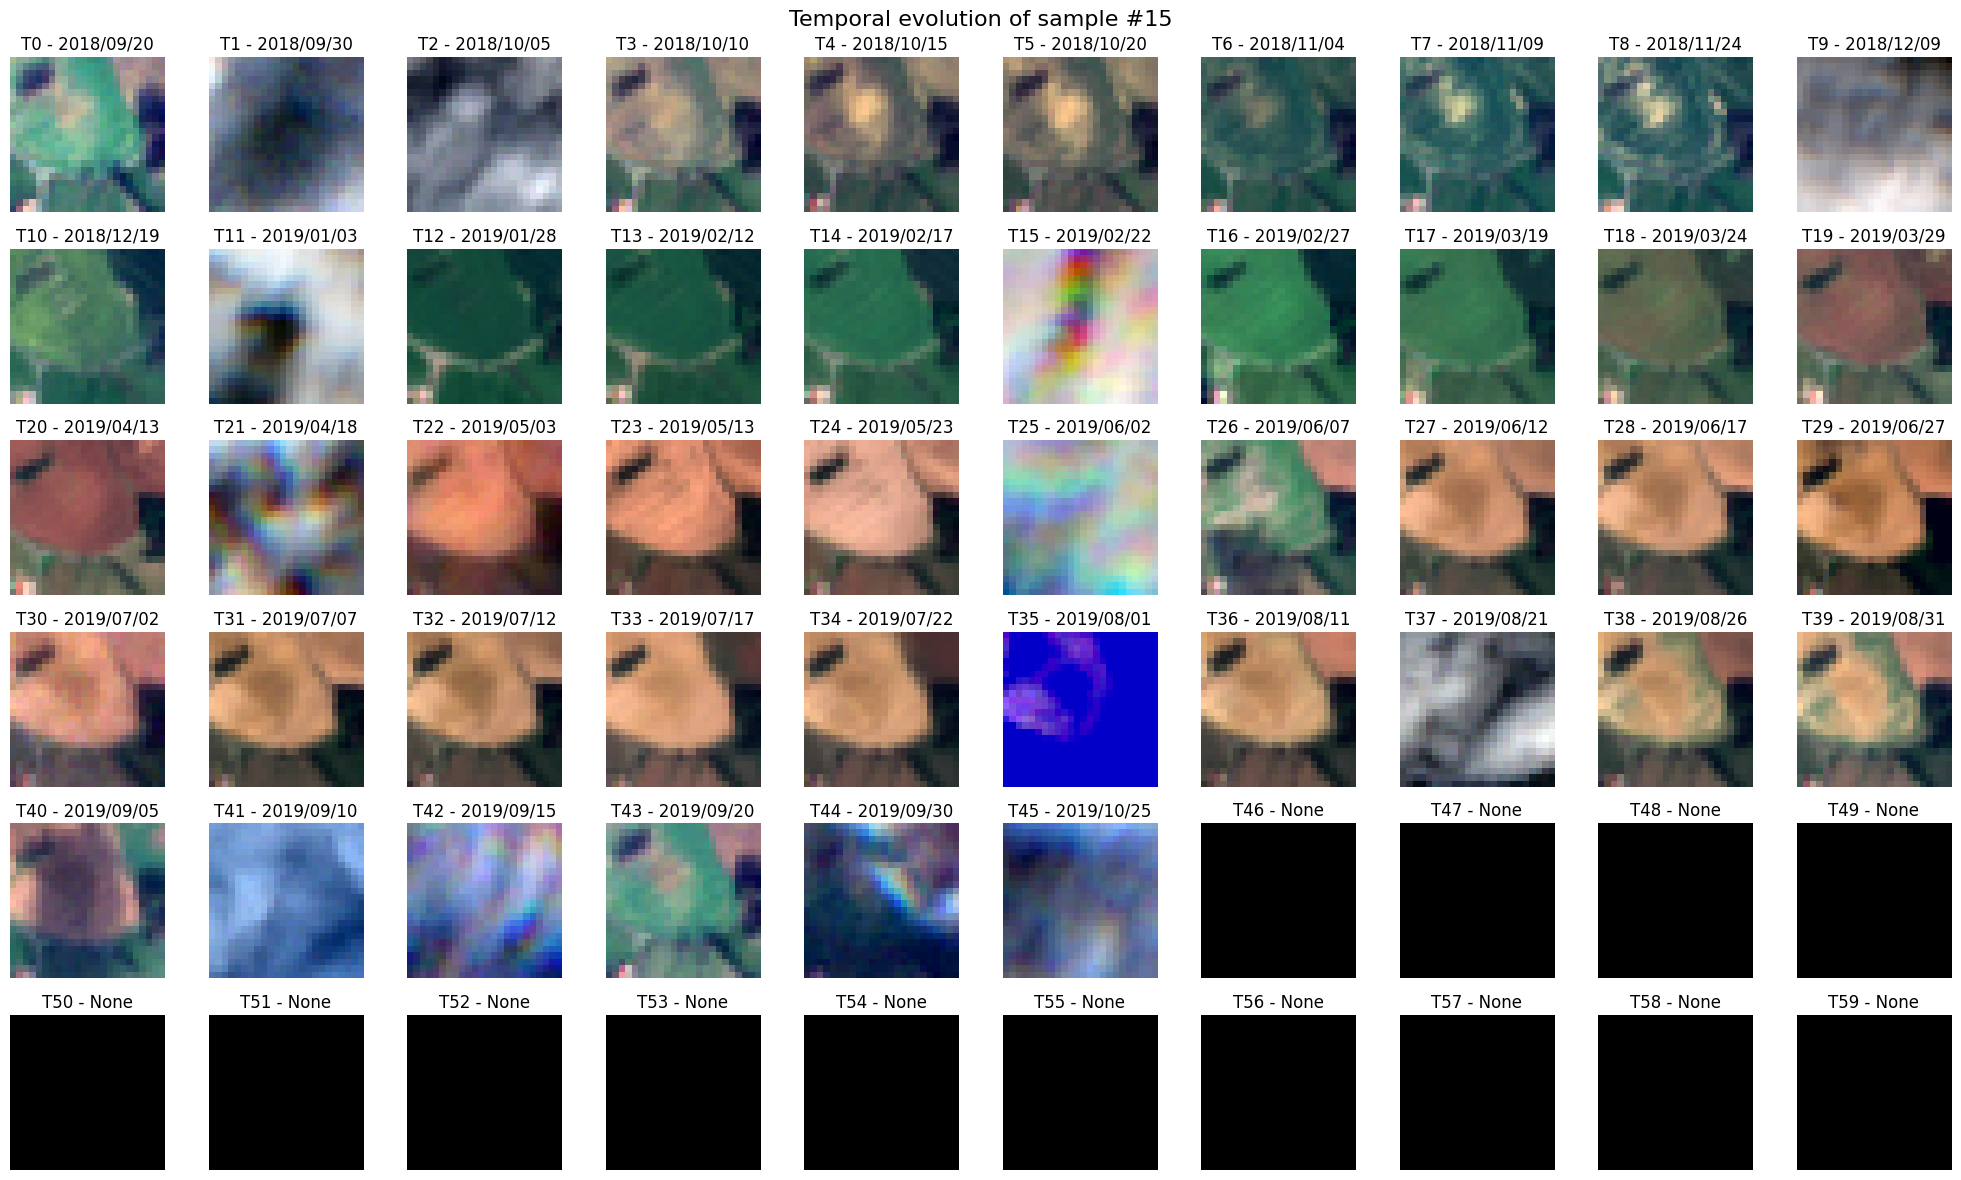

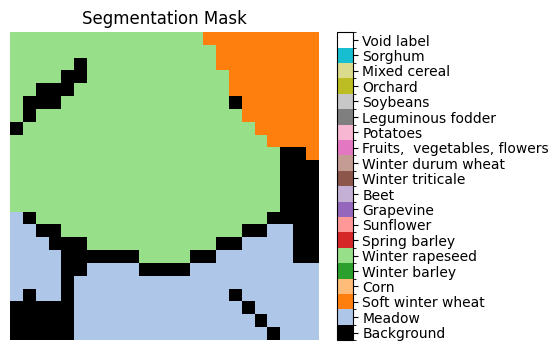

In [10]:
sample = next(iter(dataloaders['train']))
sample_idx = random.randint(0, 16)
patch_id = 'UNKNOWN'
inputs = sample[0]['inputs']
labels = sample[0]['labels']
path_patch = sample[1][sample_idx]
print(path_patch)
match = re.match(r"(\d+)_\d+\.pickle", os.path.basename(path_patch))
if match:
    patch_id = match.group(1)
sample_labels = labels[sample_idx]
plot_sample_rgb(inputs, labels, patch_id, sample_idx=sample_idx)
plot_seg_mask(sample_labels[:, :, 0], colormap, label_names_en)

## Bands (channels) analysis

Plot the mean value of pixel per band given a specific sample:

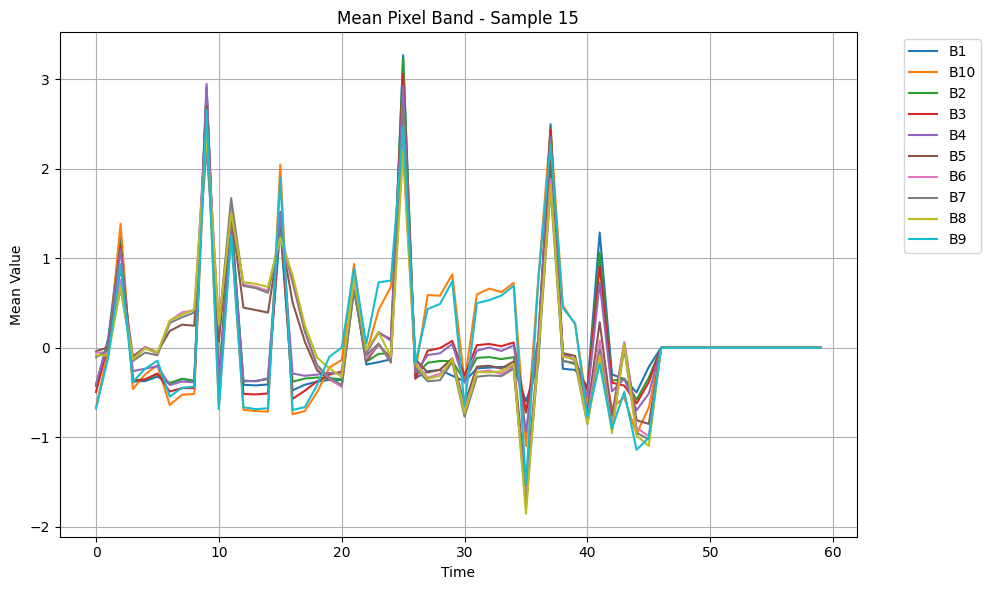

In [11]:
plot_mean_band_profile(inputs, sample_idx=sample_idx)

## NDVI

**NDVI** (Normalized Difference Vegetation Index) is an index used to assess the amount and health of vegetation on the Earth's surface using satellite images or remote sensing data.


NDVI is calculated using the **red (Red)** and **near-infrared (NIR)** bands of the satellite image. The formula is:

$$
NDVI = \frac{(NIR - Red)}{(NIR + Red)}
$$


NDVI is a value ranging from **-1 to +1**, where:

- **Values close to +1** (for example, between 0.6 and 0.9) indicate **dense and healthy vegetation**.
- **Values close to 0** (for example, between -0.1 and 0.1) indicate **areas with little or no vegetation**, such as bare soil, rocks, or urban areas.
- **Negative values** (for example, between -1 and -0.1) are typically associated with **non-vegetated surfaces** like water, snow, or clouds.

- NDVI allows scientists and farmers to monitor vegetation status and crop health remotely.
- It is useful for detecting changes in land cover and vegetation over time.
- NDVI can also be an early indicator of drought, as vegetation tends to reduce its photosynthetic activity under dry conditions.


In [12]:
import torch


def calculate_ndvi(inputs, sample_idx):
    """
    Function to calculate NDVI from the input tensor.
    The input tensor is expected to have the shape [T, H, W, B],
    where T is the number of time steps, H is the height, W is the width,
    and B is the number of bands.
    The NDVI is calculated using the formula:
    NDVI = (NIR - Red) / (NIR + Red)
    where NIR is the value of the NIR band and Red is the value of the Red band.
    The NIR band is assumed to be at index 6 and the Red band at index 7.
    The function returns a tensor with the NDVI values for each time step.
    Args:
        inputs (torch.Tensor): Input tensor of shape [T, H, W, B].
        sample_idx (int): Index of the sample to calculate NDVI for.
    Returns:
        torch.Tensor: Tensor with the NDVI values for each time step.
    """
    sample = inputs[sample_idx]  # shape: [T, H, W, B]
    num_times = sample.shape[0]

    ndvi_values = []

    for t_index in range(num_times):
        nir_band = sample[t_index, :, :, 6]  # NIR Band 6
        red_band = sample[t_index, :, :, 7]  # Red Band 7

        ndvi = (nir_band - red_band) / (nir_band + red_band)
        ndvi_values.append(ndvi)

    return torch.stack(ndvi_values)  # Tensor with the NDVI values for each time step

ndvi_tensor = calculate_ndvi(inputs, sample_idx=sample_idx)

In [13]:
ndvi_tensor.shape

torch.Size([60, 24, 24])

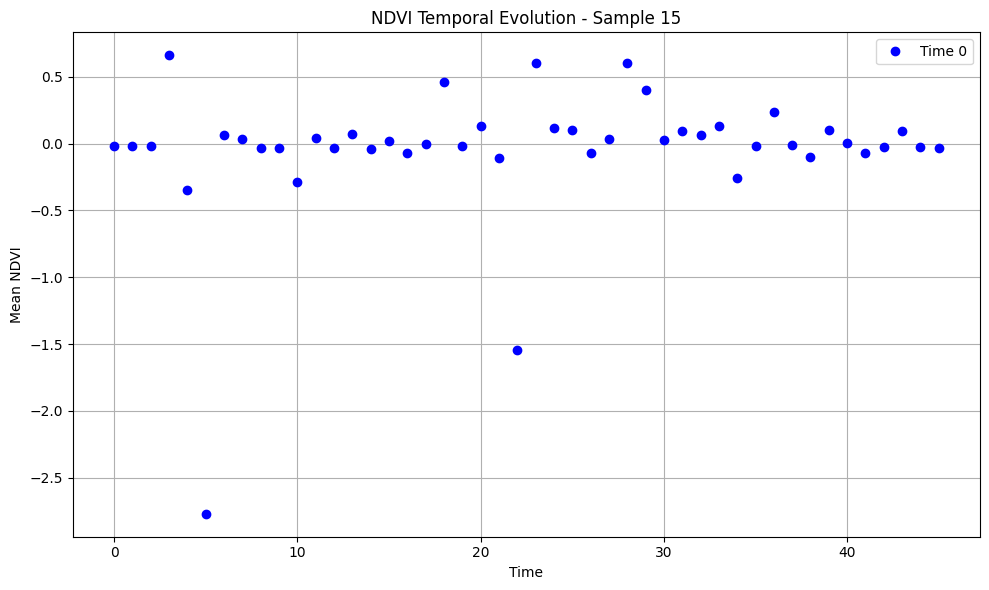

In [14]:
def plot_ndvi_over_time(ndvi_tensor, sample_idx):
    """
    Visualizes the NDVI values over time for a given sample.
    Args:
        ndvi_tensor (torch.Tensor): Tensor with NDVI values for each time step.
        sample_idx (int): Index of the sample to plot.
    """
    num_times, _, _ = ndvi_tensor.shape
    
    plt.figure(figsize=(10, 6))
    
    for t_index in range(num_times):
        mean_ndvi = ndvi_tensor[t_index].mean().item()
        plt.plot(t_index, mean_ndvi, 'bo', label=f"Time {t_index}" if t_index == 0 else "")
    
    plt.title(f"NDVI Temporal Evolution - Sample {sample_idx}")
    plt.xlabel("Time")
    plt.ylabel("Mean NDVI")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Uso:
plot_ndvi_over_time(ndvi_tensor, sample_idx=sample_idx)